## Numerical Certificates
Numerical certificates is what we call protocoles for numerically estimating the truncation error we make during propagation.
Currently, we only support a limited number of gates, i.e., `PauliRotation`s and `CliffordGate`s. 

In [1]:
using PauliPropagation
using Plots

In [2]:
nq = 25
pstr = PauliString(nq, :Z, 13)

nl = 12
topo = bricklayertopology(nq; periodic=true)

circuit = hardwareefficientcircuit(nq, nl; topology=topo);
nparams = countparameters(circuit);

We defined the usual setup, but now, instead of calling `propagate()`, we use `estimatemse()`. This function will take the almost all of our default truncations, as well as a custom truncation function, and the number of _Monte Carlo_ samples to estimate the error with. The one truncation that is not supported here is common `min_abs_coeff`. It looses its meaning in the average error we compute here. But more about that later.

### Testing Weight Truncation
Let us test the _mean square error_ we make via weight truncation, averaging over the full parameter space of the circuit's parametrized gates.

In [3]:
Ws = 0:10
mcsamples = 100_000
@time weight_errors = [estimatemse(circuit, pstr, mcsamples; max_weight=W) for W in Ws];
# where errors are zero, replace with small number to avoid log(0) error
weight_errors[weight_errors .<= 1e-10] .= 1e-10;

  1.888423 seconds (15.38 M allocations: 441.216 MiB, 2.20% gc time, 248.36% compilation time)


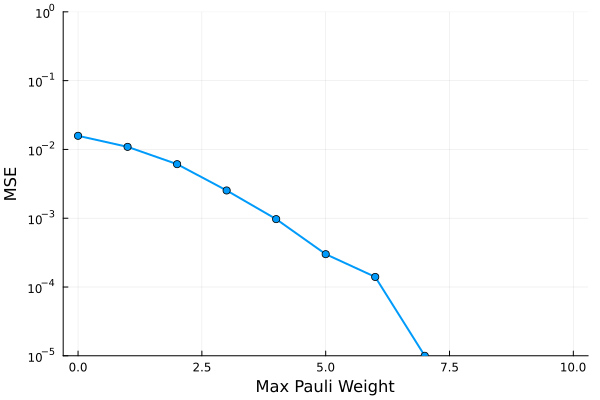

In [4]:
plot(Ws, weight_errors, yscale=:log10, xlabel="Max Pauli Weight", ylabel="MSE", ylim=(1e-5, 1e0), label="", linewidth=2, marker=:circle)

We see that the average error decause quite quickly with the maximum Pauli weight, in fact roughly exponentially. Keep in mind though, that the simulation time with `propagate` will also scale exponentially in this truncation.

### Testing Frequency Truncation
What we call _frequency_ takes the place of the `min_abs_coeff` coefficient truncation in the average case. We define frequency as the number of splits/branchings at `PauliRotation` gates. If a path has split $l$ times, then the average coefficient of that path will be $(\frac12)^l$. Note however that the error we measure here is an over-estimation! Because we _merge_ paths in `propagate()`, we can effectively propagate higher frequency paths with a lower frequency path at no additional computational cost. We don't do merging in the numerical certificate, which is why the average error will be over-estimated.

Keep in mind that we need to wrap our coefficients with `PauliFreqTracker` to track frequency.

In [5]:
wrapped_pstr = wrapcoefficients(pstr, PauliFreqTracker)

PauliString(nqubits: 25, PathProperty(PauliFreqTracker{Float64}) * IIIIIIIIIIIIZIIIIIII...)

In [6]:
freqs = 20:20:200
mcsamples = 100000

@time freq_errors = [estimatemse(circuit, wrapped_pstr, mcsamples; max_freq=freq) for freq in freqs]
# where errors are zero, replace with small number to avoid log(0) error
freq_errors[freq_errors .<= 1e-10] .= 1e-10;

  2.064193 seconds (7.54 M allocations: 318.374 MiB, 1.31% gc time, 70.14% compilation time)


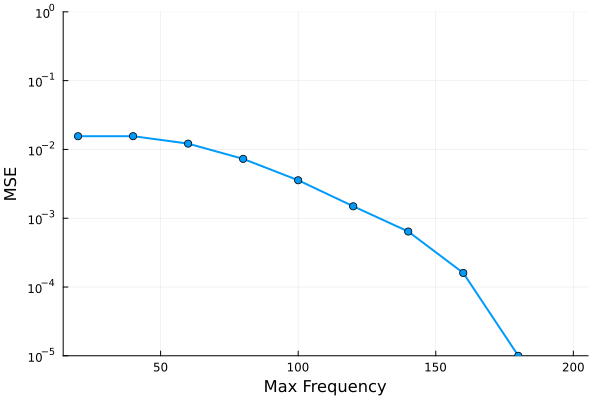

In [7]:
plot(freqs, freq_errors, yscale=:log10, xlabel="Max Frequency", ylabel="MSE", ylim=(1e-5, 1e0), label="", linewidth=2, marker=:circle)

Again, we have strongly decaying mean square error, but note that absolute value of the truncation are significantly higher that the values formaximum Pauli weight. We only reach around 1e-5 error with a frequency truncation around 180. This is a very large number and should be combined with other truncations.

More practically, if we know that the parameter range of the `PauliRotation` gates is small, we can employ the `max_sins` truncation. 

### Test Small-Angle Truncation

Here is a loop that additionally passes the _radius_ `r` for the parameters, i.e., the range around zero where they are uniformly sampled from. We thus compute the average error in a small angle range. For large radii, we expect to need significantly higher `max_sins` truncation values.

  2.186484 seconds (9.00 M allocations: 340.610 MiB, 1.91% gc time, 42.24% compilation time)
  1.951887 seconds (8.82 M allocations: 328.423 MiB)
  1.953754 seconds (8.82 M allocations: 328.423 MiB, 1.35% gc time)
  2.023746 seconds (8.82 M allocations: 328.423 MiB, 1.26% gc time)
  2.030756 seconds (8.82 M allocations: 328.423 MiB, 1.70% gc time)
  2.096559 seconds (8.82 M allocations: 328.423 MiB, 2.35% gc time)
  2.018998 seconds (8.82 M allocations: 328.423 MiB, 1.82% gc time)
  1.939388 seconds (8.82 M allocations: 328.423 MiB)
  2.039785 seconds (8.82 M allocations: 328.423 MiB, 1.77% gc time)
  2.079018 seconds (8.82 M allocations: 328.423 MiB, 2.18% gc time)


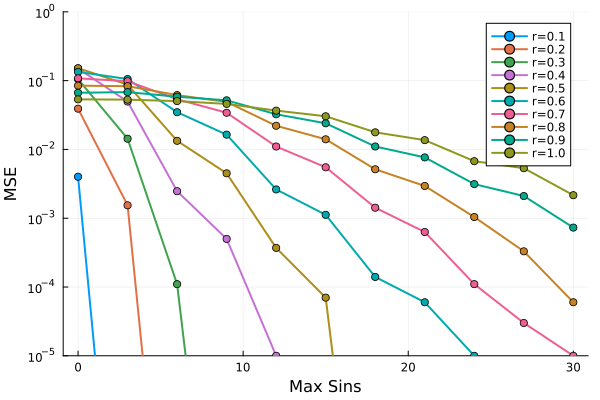

In [8]:
nsins = 0:3:30
rs = 0.1:0.1:1.0
mcsamples = 100000

pl = plot(yscale=:log10, xlabel="Max Sins", ylabel="MSE", ylim=(1e-5, 1e0))

for r in rs
    @time sins_errors = [estimatemse(circuit, wrapped_pstr, mcsamples, r; max_sins=ns) for ns in nsins]
    # where errors are zero, replace with small number to avoid log(0) error
    sins_errors[sins_errors .<= 1e-10] .= 1e-10;

    plot!(nsins, sins_errors, label="r=$(round(r, sigdigits=2))", linewidth=2, marker=:circle)
end
pl

### Combining Truncations
To get the most out of Pauli propagation, you probably want to combine truncations. Let us combine `max_sins` with `max_weight`.

  2.188612 seconds (8.96 M allocations: 354.417 MiB, 1.90% gc time, 28.09% compilation time)
  2.105925 seconds (8.82 M allocations: 345.210 MiB)
  2.136651 seconds (8.82 M allocations: 345.210 MiB, 1.34% gc time)
  2.132216 seconds (8.82 M allocations: 345.210 MiB, 2.26% gc time)
  2.121093 seconds (8.82 M allocations: 345.210 MiB, 2.21% gc time)
  2.292806 seconds (8.82 M allocations: 345.210 MiB, 2.40% gc time)
  2.223816 seconds (8.82 M allocations: 345.210 MiB, 1.24% gc time)
  2.188061 seconds (8.82 M allocations: 345.210 MiB)
  2.190732 seconds (8.82 M allocations: 345.210 MiB, 1.19% gc time)
  2.242102 seconds (8.82 M allocations: 345.210 MiB, 1.14% gc time)


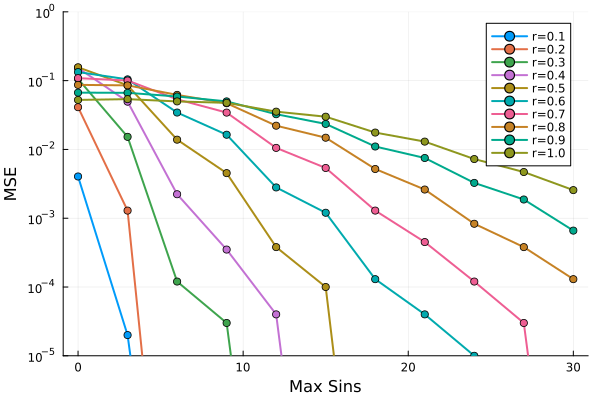

In [9]:
nsins = 0:3:30
rs = 0.1:0.1:1.0

pl = plot(yscale=:log10, xlabel="Max Sins", ylabel="MSE", ylim=(1e-5, 1e0))

for r in rs
    @time sins_errors = [estimatemse(circuit, wrapped_pstr, 100000, r; max_sins=ns, max_weight=6) for ns in nsins]
    # where errors are zero, replace with small number to avoid log(0) error
    sins_errors[sins_errors .<= 1e-10] .= 1e-10;

    plot!(nsins, sins_errors, label="r=$(round(r, sigdigits=2))", linewidth=2, marker=:circle)
end
pl

The error is pretty much identical, but we see that the runtime of `propagate` is significantly faster with both truncations:

In [10]:
using Random
Random.seed!(42)
thetas = randn(countparameters(circuit))*0.5;

In [11]:
@time psum_both = propagate(circuit, wrapped_pstr, thetas; max_sins=20, max_weight=6);
print("Number of Paulis: ", length(psum_both))

  3.846623 seconds (388.99 k allocations: 596.797 MiB, 2.86% gc time, 5.37% compilation time)
Number of Paulis: 170529

In [12]:
@time psum_sins = propagate(circuit, wrapped_pstr, thetas; max_sins=20);
print("Number of Paulis: ", length(psum_sins))

 32.847915 seconds (156.57 k allocations: 2.384 GiB, 0.52% gc time, 0.20% compilation time)
Number of Paulis: 1474496

Significantly faster but much more similarly accurate.

In [13]:
overlapwithzero(psum_both), overlapwithzero(psum_sins)

(-0.4966755215241979, -0.49375542669796074)

In [14]:
overlapwithzero(psum_both) - overlapwithzero(psum_sins)

-0.002920094826237174

In [18]:
@time psum_freq = propagate(circuit, wrapped_pstr, thetas; max_freq=40)
overlapwithzero(psum_freq)

  0.446449 seconds (5.83 k allocations: 83.331 MiB)


-0.5039732840014219